# tests of the functionalities of the EcrisBayOpt and KalmanFilterStdEst on synthetic 2D Fecris



 - Create ecris and randomly search 3 points
 - Start the optimizer
 - While loop with KF and initial Buffer zone to monitor transition
 - When transition over grab statistics and re-optimize

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import EcrisBayOps
import Fecris as venus
import KalmanFilterStdEst as kfilt


# warning ignored because the tuning of alpha is supposed to test the convergence of the optimizer
import warnings
warnings.filterwarnings("ignore")

Setting the parameters of the test

In [116]:
# parameters of the Kalman filter
cMeas = 1e3 # filter parameter the increase to filter more decrerasse to track faster
slopeMax  = .0001 # slope used to determine if the system is settled

# parameters for the bayesian optimizer
Klen = [.05,.05] # kernel length
alpha = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2] # possible values for alpha
exBias = 2.5 # exploration exploitation bias
risk = .2 # acceptable rsik of evaluating an unstable area
thresh = .05 # stability threshold
expNoise = .01 # expected noise level
limits = np.asarray([[0,0],[1,1]]) # limits of the exploration space

Disp = True # Turns on display at every step

Initializing with 3 random evaluations

In [117]:
# lists for data storage and display
storeMeas = []
slope = []
FilteredI = []

Settings = np.random.rand(3, 2) # Settings where the Fecris will ber evaluated
myEcris = venus.FECRIS2D(Settings[0]) # creating the ion source object with the initial state
Y = [] # list for output (beam current)
S = [] # list for stability
tmp = []
# getting the fisrt statistics the old way
for k in range(100):
    tmp.append(myEcris.read())
Y.append(np.mean(tmp))
S.append(np.std(tmp))

# evaluating the first 3 random Settings
for k in range(len(Settings)-1):
    unsettled = True
    KF = kfilt.KFobject(myEcris.read(), cMeas) # reinitialize Kalman filter for every new settings
    inftyLoop = 0
    while(unsettled): # going through the transition
        inftyLoop += 1
        measure = myEcris.Transition(Settings[k+1])# getting a transition measurement from the Fecris
        deltaT = np.random.randn() * .3 + .1 # forcing irregular sampling
        KF.EstimateState(measure, deltaT) # Filtering the new measure
        if inftyLoop > 20: # after 20 call we start to evaluate the slope to see if the system has settled
            if np.prod(np.abs(slope[len(slope)-11::]) < slopeMax): # if the last 10 values of the slope meet the settling criterion
                unsettled = False
                Y.append(KF.X[0])# grabing the filtered output value
                S.append(KF.Sig[0]/KF.X[0]) # calculating the stability value
                myEcris.SetState(Settings[k+1]) # !!!! Important !!!! before moving to a new transition we force Fecris to new state
                #print('settled at t=', inftyLoop) # how many call were needed for the system to settle

        if inftyLoop > 5000: # if the system never settles
            #print('timeout')
            # grabing values but will pollute data set
            Y.append(KF.X[0])
            S.append(KF.Sig[0]/KF.X[0])
            unsettled = False
            myEcris.SetState(Settings[k + 1])
        # storing values for display
        storeMeas.append(measure)
        FilteredI.append(KF.X[0])
        slope.append(KF.X[1])


Opt = EcrisBayOps.Optimizer(Klen, alpha, exBias, expNoise, risk, thresh) # building the optimizer

k = 0 # initilaizing search counter

Going through the loop: run next cell as many time as you want every run get the next optimized query

settled at t= 335


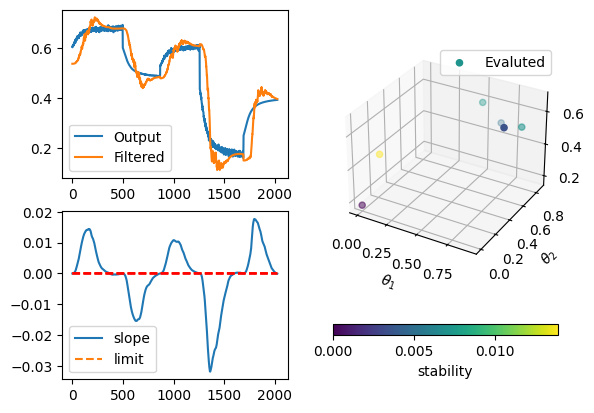

In [120]:
nextSet = EcrisBayOps.NextPointQuery(Settings, Y, S, Opt, limits) # getting next settings
# going through the same steps as followed during the random search
unsettled = True
KF = kfilt.KFobject(myEcris.read(), cMeas)
inftyLoop = 0
while unsettled:
    inftyLoop += 1
    measure = myEcris.Transition(nextSet)
    deltaT = np.random.randn() * .3 + .1
    KF.EstimateState(measure, deltaT)
    if inftyLoop > 20 :
        if np.prod(np.abs(slope[len(slope)-11::]) < slopeMax):
            unsettled = False
            Y.append(KF.X[0])
            S.append(KF.Sig[0]/KF.X[0])
            Settings = np.concatenate((Settings, [nextSet]))
            myEcris.SetState(nextSet)
            print('settled at t=', inftyLoop)

    if inftyLoop > 5000 :
        print('timeout')
        nextSet = np.random.rand(2)
        Settings = np.concatenate((Settings, [nextSet]))
        Y.append(KF.X[0])
        S.append(KF.Sig[0] / KF.X[0])
        unsettled = False
        myEcris.SetState(nextSet)

    storeMeas.append(measure)
    FilteredI.append(KF.X[0])
    slope.append(KF.X[1])
if Disp:
    fig = plt.figure()
    ax = fig.add_subplot(122, projection='3d')
    p = ax.scatter(Settings[0:k+4, 0], Settings[0:k+4, 1], Y[0:k+4], c = S[0:k+4], cmap ='viridis')
    inds = np.where(np.asarray(S[0:k+4]) > .05)[0]
    if len(inds):
        ax.scatter(Settings[inds, 0], Settings[inds, 1], np.asarray(Y)[inds], marker = 'x', color = 'red')
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$\theta_2$')
    ax.set_zlabel(r'$\mathcal{I}$')
    ax.legend(['Evaluted', 'Unstable'])
    fig.colorbar(p, orientation = "horizontal", label= "stability")
    ax1 = fig.add_subplot(221)
    ax1.plot(storeMeas)
    ax1.plot(FilteredI)
    ax1.legend(['Output', 'Filtered'])
    ax2 = fig.add_subplot(223)
    ax2.plot(slope)
    ax2.plot(np.ones(len(slope))*slopeMax, '--')
    ax2.plot(np.ones(len(slope)) * slopeMax, 'r--')
    ax2.plot(-np.ones(len(slope)) * slopeMax, 'r--')
    ax2.legend(['slope', 'limit'])
    plt.show()
k+=1 # incrementing counter